Expected Instrumental Noise from the test masses and the Optical Metrology Subsystem (OMS).
TODO: Make this into a python script and a function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lisatools.utils.constants import *
from copy import deepcopy 
from lisatools.sensitivity import SensitivityMatrix, A1TDISens,E1TDISens, T1TDISens, LISASens, X1TDISens
import noise_generation as noise_generation

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


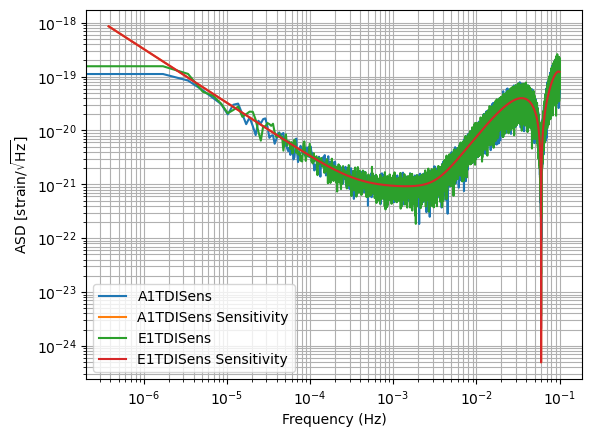

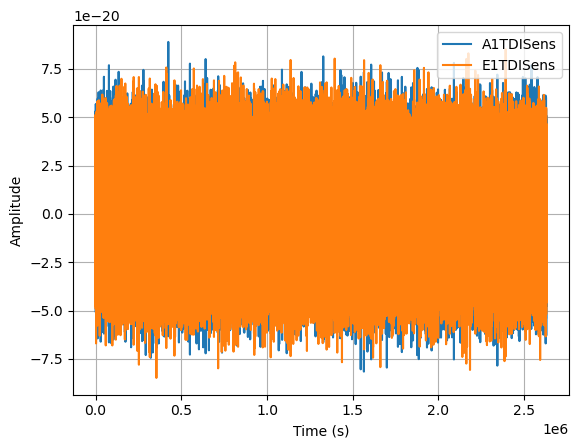

In [2]:
# Tobs is the obvesrvation time in seconds. YRSID_SI is a siderial year = 31558149.763545603 seconds
Tobs = YRSID_SI / 12.  # 1 month

# This is the sampling interval, i.e., the time between two samples. The sampling rate is 1/dt
dt = 5.  # sec

# N is the number of samples in your original time-domain signal.
N = int(Tobs / dt)

# Convert Tobs into an integer number.
Tobs = N * dt

# This function returns the array of sample frequencies corresponding to the positive frequencies of the real-input Fast Fourier Transform (rFFT)
# The list goes from from zero to the Nyquist frequency, which is half the sampling rate: f[-1] = df/2 = 1/(2*dt)
# len(f) = floor(N/2) + 1 because the Nyquist frequency is included and the negative frequencies are not included in the rFFT
freq = np.fft.rfftfreq(N,dt)

# f[0] is 0.0. To avoid this, set f[0] to f[1]
freq[0] = freq[1]

# stochastic_params in sens_kwargs takes the time to add galactic foreground noise. It makes sense to put it as Tobs, which is the duration of observation.
# This is why N was calculated using Tobs and not written explicitly.
sens_kwargs = dict(
        stochastic_params=(Tobs,)
    )

# SensitivityMatrix class gives a model of the LISA instrumental noises, given a frequency array, for every TDI channel in sens_model_array
sens_mat = SensitivityMatrix(freq, [A1TDISens, E1TDISens])#, **sens_kwargs)

noises = noise_generation.generate_noise(N, dt, sens_mat, seed = 42, verification_plot=True, time_domain_plot=True, plot_lables=['A1TDISens', 'E1TDISens'])


In [3]:
# Get the time vector from dt and N. The time above is time steps. 

In [4]:
from scipy.signal.windows import hann
from scipy.signal import welch

def noise_time_to_freq_domain(noise, dt):
    fs = 1/dt
    win_length = int(len(noise) / 4.5)
    window = hann(win_length)
    
    # Compute the power spectral density using Welch's method
    fout, pxxout = welch(noise, window=window, noverlap=0, nfft=None, fs=fs, return_onesided=True)
    return fout, pxxout

fout = []
pxxout = []
for noise in noises:
    f, pxx = noise_time_to_freq_domain(noise, dt)
    fout.append(f)
    pxxout.append(pxx)
fout = np.array(fout)
pxxout = np.array(pxxout)


In [ ]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))

m1 = 1e6
m2 = 7e5
# a1 and a2 are the dimensionless spins of the two black holes assumed to be aligned with the orbital angular momentum.
a1 = 0.5
a2 = 0.7
dist = 200 * 1e9 * PC_SI
phi_ref = 0.0
f_ref = 0.0
inc = np.pi/3.
beta = np.pi/4.  # ecliptic latitude
lam = np.pi/5.  # ecliptic longitude
psi = np.pi/6.  # polarization angle
t_ref = Tobs - 60*60*24  # t_ref  (in the SSB reference frame) = merger time.

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]

wave = wave_gen(m1, m2, a1, a2,
                dist, phi_ref, f_ref, inc, lam,
                beta, psi, t_ref, 
                freqs=freq, modes=modes, 
                direct=False, fill=True, squeeze=True, length=1024)[0][:2]

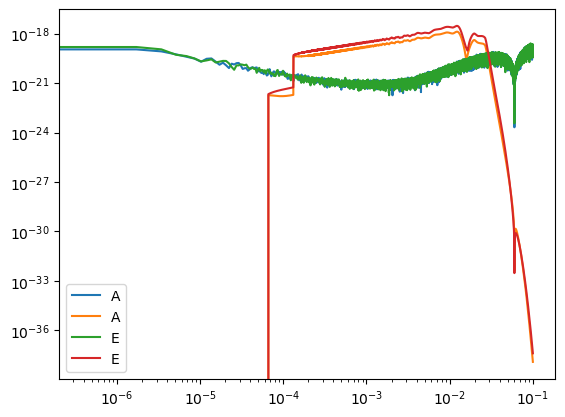

In [95]:
for i, let in enumerate(["A", "E"]):
    plt.loglog(fout[i], np.sqrt(pxxout[i]), label=let)
    plt.loglog(freq, np.abs(wave[i]), label=let)

plt.legend()

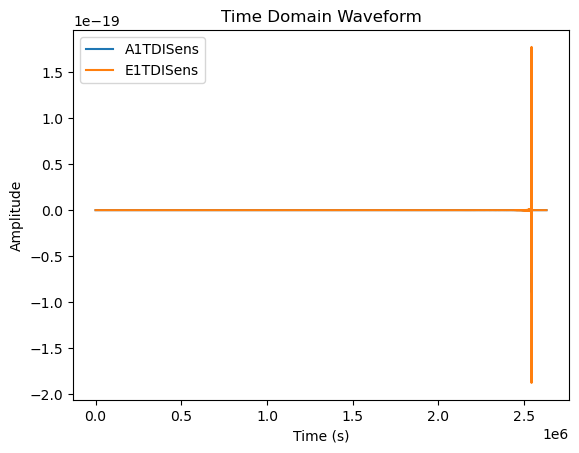

In [96]:
wave_time_domain = np.fft.irfft(wave, axis=-1)
plt.figure()
plt.plot(np.arange(len(wave_time_domain[0]))*dt, wave_time_domain[0], label='A1TDISens')
plt.plot(np.arange(len(wave_time_domain[1]))*dt, wave_time_domain[1], label='E1TDISens')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Waveform')
plt.legend()

In [97]:
wave_with_noise = wave_time_domain+ noises


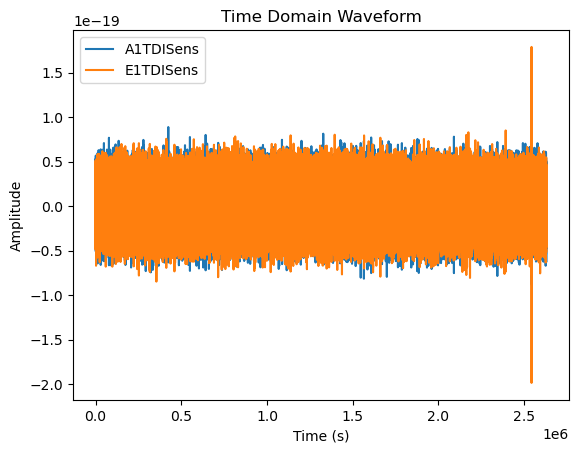

In [98]:
plt.plot(np.arange(len(wave_with_noise[0]))*dt, wave_with_noise[0], label='A1TDISens')
plt.plot(np.arange(len(wave_with_noise[1]))*dt, wave_with_noise[1], label='E1TDISens')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Waveform')

plt.legend()


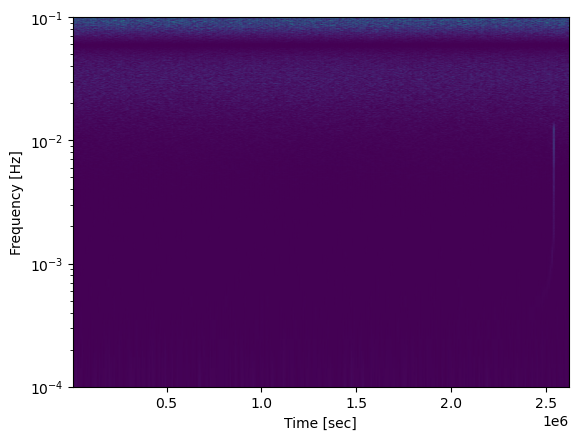

In [ ]:
from scipy.signal import spectrogram
#spectrogram(wave_with_noise[0], fs=1.0/dt, window=('tukey', 0.25), nperseg=None, noverlap=None,mode='psd')
f, t, Sxx = spectrogram(wave_with_noise[0], fs=1.0/dt, window=('tukey', 0.25), nperseg=2000, mode='magnitude')
plt.pcolormesh(t, f, Sxx, shading='gouraud')

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(f[1], f[-1])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (262985,) and (525968,)

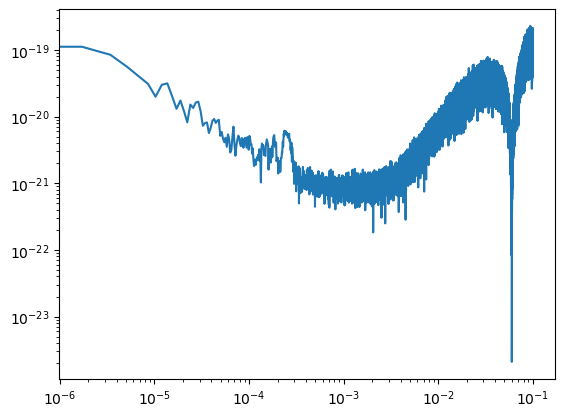

In [54]:
fout_withnoise = []
pxxout_withnoise = []
for element in wave_with_noise:
    f, pxx = noise_time_to_freq_domain(element, dt)
    fout_withnoise.append(f)
    pxxout_withnoise.append(pxx)
fout_withnoise = np.array(fout_withnoise)
pxxout_withnoise = np.array(pxxout_withnoise)

for i, let in enumerate(["A", "E"]):
    plt.loglog(fout[i], np.sqrt(pxxout_withnoise[i]), label=let)
    plt.loglog(freq, np.abs(wave_with_noise[i]), label=let)

plt.legend()

make a new script with the mcmc framework based on tut4 in the freq domain(check) tref, m1, m2 
switch to the sky loc later. 
time freq representation later.